# Why are the measures to similar?

If the voltage shapes are very similar, then $(V-E_{Na})$ is just a proportionality factor. In that case, both metrics will be very similar.

What if the voltage shapes are not similar, e.g. one spike is high and one is low? The big part of the energy is consumed when $(V - E_{Na})$ is large, i.e. in the regime where the spikes are still in their "early phase". This phase exists in both high and low spikes and within this range, the voltage waveforms are very similar. The difference in voltage waveforms only appears at high voltages (one spike still increasing, other flattening out). However, in this regime, the consumed energy is generally low due to a low $(V - E_{Na})$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyloric import simulate, create_prior, summary_stats
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import torch
from matplotlib.patches import Rectangle
import stg_energy.fig1_energy.viz_appendix as viz
prior = create_prior()

In [5]:
def curr_currents(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        track_currents=True,
        energy_measure="current"
    )
    return out_target

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

In [7]:
n_samp = 20
samples = theta[:n_samp]
data_np = samples.to_numpy()
params_with_seeds = np.concatenate((data_np, np.expand_dims(seeds[:n_samp], axis=1)), axis=1)

In [8]:
with Pool(16) as pool:
    start_time = time.time()
    data1 = pool.map(curr_currents, params_with_seeds)
    print("Simulation time", time.time() - start_time)

Simulation time 9.252563953399658


# Sodium

In [9]:
conductance_ind = 0
reversal_potential = 50

In [10]:
time_vec = np.arange(0, 11000, 0.025)

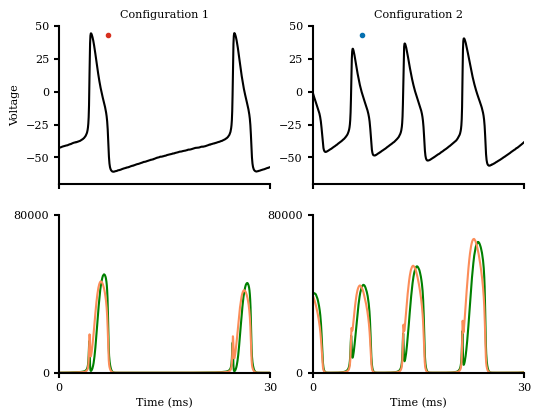

In [11]:
ratio0, ratio1 = viz.generate_figure_small(data1, time_vec, conductance_ind, reversal_potential, 43300, 44500, ind1=0, ind2=2, name="1")

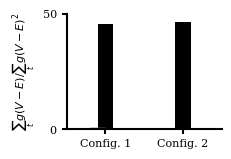

In [12]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    ax.bar([0, 1], [ratio0, ratio1], color="k", width=0.2)
    ax.set_ylim([0, 50.0])
    ax.set_yticks([0, 50.0])
    ax.set_ylabel(r"$\sum_t g(V-E)/\sum_t g(V-E)^2$")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Config. 1", "Config. 2"])
    ax.add_patch(Rectangle((-0.2, 0.34), 0.2, 0.1,  color="g"))
    ax.add_patch(Rectangle((-0.2, 0.54), 0.2, 0.1,  color="#fc8d59"))
    ax.set_xlim([-.5, 1.5])
    plt.savefig("../svg/panel_explanation_of_proportionality_c1.svg")

# Energy computation based on sodium

In [13]:
powers = []
currents = []
for index in range(20):
    _, power, current = viz.energy_of_current(data1, index, conductance_ind, reversal_potential, 40000, 440000)
    powers.append(np.sum(power))
    currents.append(np.sum(current))

In [14]:
rho = np.corrcoef(powers, currents)[0, 1]
print(rho)

0.9991356605801358


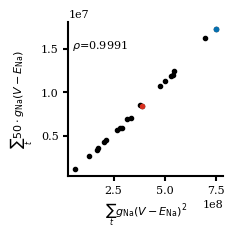

In [19]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.scatter(powers, currents, c="k")
    _ = ax.scatter(powers[0], currents[0], c="#d7301f")
    _ = ax.scatter(powers[2], currents[2], c="#0570b0")
    ax.set_xlabel(r"$\sum_t g_{\mathrm{Na}} (V-E_{\mathrm{Na}})^2$")
    ax.set_ylabel(r"$\sum_t 50 \cdot g_{\mathrm{Na}} (V-E_{\mathrm{Na}})$")
    ax.text(.5e8, 1.5e7, r"$\rho$"+f"={rho:.4f}")
    plt.savefig("../svg/panel_explanation_of_proportionality_a1.svg")

## Assemble figure

In [20]:
import IPython.display as IPd
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [21]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "10.4cm",

           Panel(
          SVG("../svg/panel_explanation_of_proportionality_b1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", -5.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(5*factor_svg, 2*factor_svg),
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_a1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(100*factor_svg, 34*factor_svg),
           
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_c1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", -2.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(102*factor_svg, 2*factor_svg),
)

f.save("../fig/fig1_supp_explanation.svg")
svg('../fig/fig1_supp_explanation.svg')

# Energy computation based on potassium

In [22]:
conductance_ind = 5
reversal_potential = -80

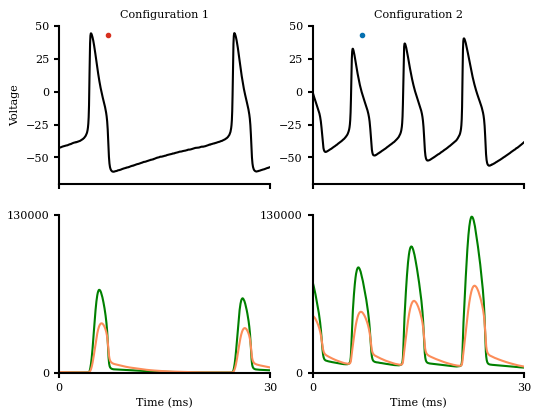

In [25]:
ratio0, ratio1 = viz.generate_figure_small(data1, time_vec, conductance_ind, reversal_potential, 43300, 44500, ind1=0, ind2=2, ymax=130000, name="2")

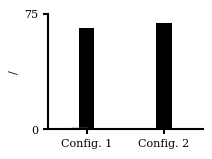

In [26]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
    ax.bar([0, 1], [ratio0, ratio1], color="k", width=0.2)
    ax.set_ylim([0, 75])
    ax.set_yticks([0, 75])
    ax.set_ylabel("/")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Config. 1", "Config. 2"])
    ax.add_patch(Rectangle((-0.2, 0.34*1.5), 0.2, 0.1*1.5,  color="g"))
    ax.add_patch(Rectangle((-0.2, 0.54*1.5), 0.2, 0.1*1.5,  color="#fc8d59"))
    ax.set_xlim([-.5, 1.5])
    plt.savefig("../svg/panel_explanation_of_proportionality_c2.svg")

In [27]:
powers = []
currents = []
for index in range(20):
    _, power, current = viz.energy_of_current(data1, index, conductance_ind, reversal_potential, 40000, 440000)
    powers.append(np.sum(power))
    currents.append(np.sum(current))

In [28]:
rho = np.corrcoef(powers, currents)[0, 1]
print(rho)

0.9973594491430214


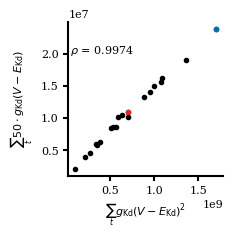

In [32]:
n = n_samp
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = ax.scatter(powers, currents, c="k")
    _ = ax.scatter(powers[0], currents[0], c="#d7301f")
    _ = ax.scatter(powers[2], currents[2], c="#0570b0")
    ax.set_xlabel(r"$\sum_t g_{\mathrm{Kd}} (V-E_{\mathrm{Kd}})^2$")
    ax.set_ylabel(r"$\sum_t 50 \cdot g_{\mathrm{Kd}} (V-E_{\mathrm{Kd}})$")
    ax.text(.5e8, 2e7, r"$\rho$"+f" = {rho:.4f}")
    plt.savefig("../svg/panel_explanation_of_proportionality_a2.svg")

In [33]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "10.4cm",

    Panel(
          SVG("../svg/panel_explanation_of_proportionality_b2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", -5.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(5*factor_svg, 2*factor_svg),
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_a2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(100*factor_svg, 34*factor_svg),
           
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_c2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", -2.0*factor_svg, 0.6*factor_svg, **kwargs_text),
    ).move(102*factor_svg, 2*factor_svg),
)

f.save("../fig/fig1_supp_explanation2.svg")
svg('../fig/fig1_supp_explanation2.svg')